# Image Compression


## Singular Value Decomposition (SVD)
$$ A = U\Sigma V^T $$
$$ U = \text{(mxm), columns are eigenvectors of } AA^T $$
$$ \Sigma = \text{(mxn), $r$ (rank(A)) singular values on diagonal } A^T A $$
$$ V = \text{(nxn), columns are eigenvectors of } A^T A $$

We also know what $\Sigma$ looks like 

$$
\Sigma = 
\begin{pmatrix}
    \sigma_1 && \\
    &\sigma_2  & \\
    && \ddots   \\
    &&& \sigma_r \\
    &&&& 0 \\
    &&&&& \ddots \\
    &&&&&& 0 \\
\end{pmatrix}
$$

This means that all columns $u_j \in U$ for $j > r$ can be removed because they will just be multiplied by zero. This also means that we will only need to multiply by the first $r$ rows of $V^T$ which equals the first $r$ columns of $V$.

So our reduced SVD becomes:
$$ A = \bar{U}\bar{\Sigma} \bar{V}^T $$
$$ \bar{U} = \text{(mxr)} $$
$$ \bar{\Sigma} = \text{(rxr)} $$
$$ \bar{V} = \text{(nxr)}$$

When singular values that are equal to zero exists we get a dimension reduction with no changes to our matrix. Another idea is to remove singular values that are close to zero and are not particularly "important" for reconstructing $A$.

In [8]:
from collections import Counter

%matplotlib inline
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy as sp
from scipy import ndimage
import scipy.fftpack as fft
from scipy import sparse

from ipywidgets import interact, FloatSlider

# Local Imports
from utils.img_proc.sliding_window import sliding_window
from utils.misc.Huffman import encode

def show(img):
    return plt.imshow(img, cmap=plt.cm.gray)

In [24]:
# Image Information
rgb_img = ndimage.imread("data/puppy.jpg")
#gray_img = ndimage.imread("data/graycard.jpg",)
gray_img = ndimage.imread('data/obama.png')

In [134]:
U, Sigma, Vh = sp.linalg.svd(gray_img)

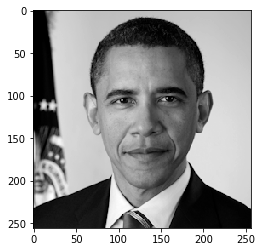

In [135]:
no_loss = np.dot(U, np.dot(sp.linalg.diagsvd(Sigma,gray_img.shape[0],gray_img.shape[1]), Vh))
show(no_loss)

Bytes Used: 513
Compression Ratio 0.00782775878906


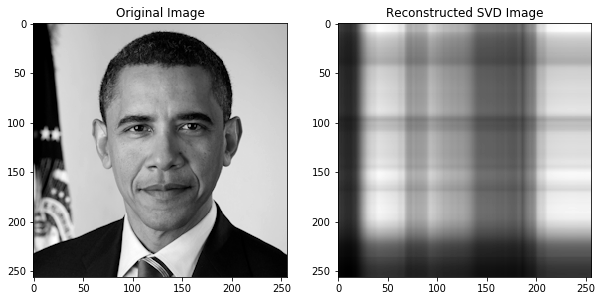

In [185]:
# See how the number of singular values used effects the visual quality of an 
# image and the amount of storage neeeded
U, Sigma, Vh = sp.linalg.svd(gray_img)

gray_img_svd_slider = FloatSlider(min=1, max=gray_img.shape[0], step=1, value=1)

# i is the number of singular values used to make the image
@interact(num_sing_vals=gray_img_svd_slider)
def plot_image_using_singular_values(num_sing_vals):
    i = int(num_sing_vals)
    total_bytes = np.matrix(U[:,:i]).size + Sigma[:i].size + np.matrix(Vh[:i, :]).size
    print("Bytes Used:", total_bytes)
    print("Compression Ratio", total_bytes/np.prod(gray_img.shape))
    
    U_1 = np.matrix(U[:,:i])
    Sigma_1 = np.diag(Sigma[:i])
    V_t = np.matrix(Vh[:i, :])
    
    result = U_1* Sigma_1 * V_t
    histogram_data = result.flatten().T
    
    f = plt.figure(figsize=(10,10))
    f.add_subplot(1, 2, 1)  # this line outputs images side-by-side
    plt.title("Original Image")
    show(gray_img)
    f.add_subplot(1,2,2)
    plt.title("Reconstructed SVD Image")
    show(result)

0.00984191894531
0.00715


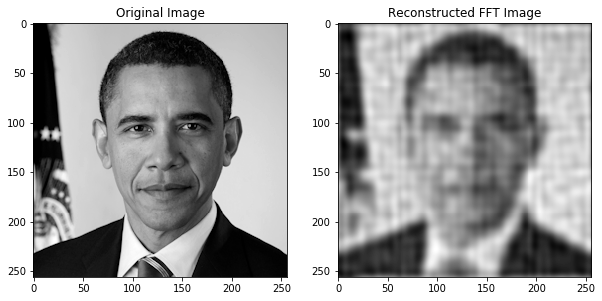

In [184]:
gray_img_fft_slider = FloatSlider(min=0, max=.01, step=0.00005, value=0)

img_fft = fft.fft2(gray_img)
M = np.max(np.abs(img_fft))
# i is the number of singular values used to make the image
@interact(thresh=gray_img_fft_slider)
def plot_image_using_fft2(thresh):
    truncated_image = (np.abs(img_fft) > M*thresh) * img_fft    
    print((np.sum(np.abs(truncated_image > 0))*3)/np.prod(gray_img.shape))
    print(thresh)
    #total_bytes = np.sum(np.abs(truncated_image > 0))
    #print("Bytes Used:", total_bytes)
    #print("Compression Ratio", total_bytes/num_pixels)
    
    reconstructed_image = np.real(fft.ifft2(truncated_image))
    
    f = plt.figure(figsize=(10,10))
    f.add_subplot(1, 2, 1)  # this line outputs images side-by-side
    plt.title("Original Image")
    show(gray_img)
    f.add_subplot(1,2,2)
    plt.title("Reconstructed FFT Image")
    show(reconstructed_image)

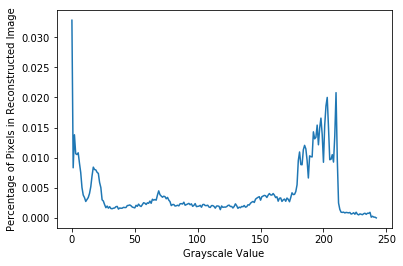

In [145]:
# See how the number of singular values used effects distribution of grayscale values
# used in the reconstructed image
U, Sigma, Vh = sp.linalg.svd(gray_img)
pdf_slider = FloatSlider(min=1, max=gray_img.shape[0], step=1, value=800)

def set_max(a):
        return a if (a<256) else 255

# i is the number of singular values used to make the image
@interact(i=pdf_slider)
def plot_reconstructed_image_pdf(i):
    i = int(i)

    approx_A = np.dot(U[:,:i], np.dot(np.diag(Sigma[:i]), Vh[:i, :]))
    approx_A_list = approx_A.flatten()
    approx_A_list = approx_A_list.astype(int)

    vfunc = np.vectorize(set_max)
    rounded_approx_A_list = vfunc(approx_A_list)

    approx_A_values, approx_A_counts = np.unique(rounded_approx_A_list, return_counts=True)
    approx_A_count_percs = approx_A_counts/np.prod(gray_img.shape)
    
    plt.xlabel("Grayscale Value")
    plt.ylabel("Percentage of Pixels in Reconstructed Image")
    plt.plot(approx_A_values, approx_A_count_percs)

## Compression Ratio vs Image Quality

We define the compression ratio as the amount of space required to store an image in its factorized form divided by the amount of space required to store the raw image (the matrix $A$ which is (mxn)). This can be written as a function of $i$, the number of singular values used.

$$ CompressionRatio = \frac{(m*i)+(i)+(i*n)}{m*n} $$

We can also quantify image quality. Informally we can think of it as the difference in absolute value between the original image, $A$, and the processed and reconstructed image, $B$. 

$$ Error = \frac{\sqrt{\sum_i \sum_j (a_{i,j}-b_{i,j})^2}}{\sqrt{\sum_i \sum_j a_{i,j}^2}} = \frac{||A-B||^2}{||A||^2}$$

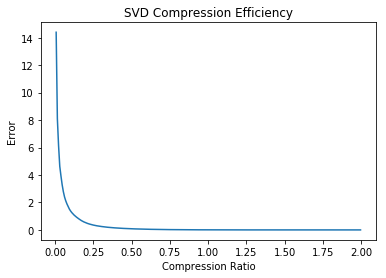

In [20]:
U, Sigma, Vh = sp.linalg.svd(gray_img)
compression_ratios = []
approximation_errors = []

for i in range(1,gray_img.shape[0]):
    compression_ratios.append((np.matrix(U[:,:i]).size + Sigma[:i].size + np.matrix(Vh[:i, :]).size)/np.prod(gray_img.shape))
    approx_A = np.dot(U[:,:i], np.dot(np.diag(Sigma[:i]), Vh[:i, :]))
    approximation_errors.append(((LA.norm(gray_img - approx_A)**2)/(LA.norm(gray_img)**2))*100)

plt.xlabel("Compression Ratio")
plt.ylabel("Error")
plt.title("SVD Compression Efficiency")
plt.plot(compression_ratios, approximation_errors)

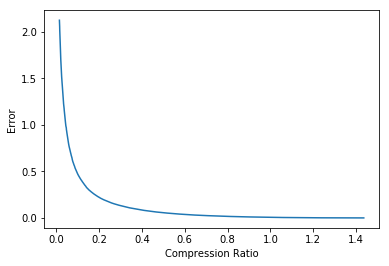

In [21]:
# This may not (I don't think it is) a valid way to measure the compression ratio.
# If you still have to store zeros is that a reduction in space? (No?)

fft_compression_ratios = []
fft_approximation_errors = []

img_fft = fft.fft2(gray_img)
M = np.max(np.abs(img_fft))
for thresh in np.arange(0,0.005,0.00001):
    truncated_image = (np.abs(img_fft) > M*thresh) * img_fft
    fft_compression_ratios.append((np.sum(np.abs(truncated_image > 0))*3)/np.prod(gray_img.shape))
    fft_approximation_errors.append(((LA.norm(gray_img - np.real(fft.ifft2(truncated_image)))**2)/(LA.norm(gray_img)**2))*100)

plt.xlabel("Compression Ratio")
plt.ylabel("Error")
plt.plot(fft_compression_ratios, fft_approximation_errors)

print()

In [3]:
haar_compression_ratios = []
haar_approximation_errors = []

M = np.max(np.abs(gray_img))

# Get all of the 8x8 submatrices (windows)
windows = sliding_window(gray_img, (8,8), flatten=False)
template = np.zeros(windows.shape)

def haar_transform(sub_matrix,val):
    return np.matmul(np.matmul(W.T,sub_matrix),W)

for i, x in enumerate(windows):
    for j, y in enumerate(x):
        template[i][j] = np.apply_over_axes(haar_transform, windows[i][j], [0])

stored_image = np.ma.row_stack([np.ma.column_stack(template_window) for template_window in template])

compressed_windows = sliding_window(stored_image, (8,8), flatten=False)
reconstructed_template = np.zeros(windows.shape)

def inverse_haar(sub_matrix,val):
    return np.matmul(np.matmul(LA.inv(W.T),sub_matrix),LA.inv(W))

"""

for thresh in np.arange(0,0.5,0.001):

    filtered_image = (np.abs(stored_image) > M*thresh) * stored_image
    filtered_windows = sliding_window(filtered_image, (8,8), flatten=False)
    filtered_template = np.zeros(filtered_windows.shape)
    
    for i, x in enumerate(filtered_windows):
        for j, y in enumerate(x):
            filtered_template[i][j] = np.apply_over_axes(inverse_haar, filtered_windows[i][j], [0])
    
    reconstructed_filtered_image = np.ma.row_stack([np.ma.column_stack(re_temp) for re_temp in filtered_template])
    haar_compression_ratios.append((len(filtered_image[np.where(filtered_image>0)])*3)/np.prod(gray_img.shape))
    haar_approximation_errors.append(((LA.norm(gray_img - reconstructed_filtered_image)**2)/(LA.norm(gray_img)**2))*100)
    """

NameError: name 'W' is not defined

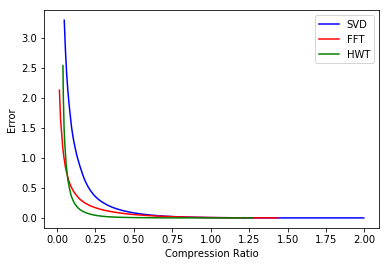

In [58]:
plt.xlabel("Compression Ratio")
plt.ylabel("Error")
plt.plot(compression_ratios[5:], approximation_errors[5:],color='blue',label='SVD')
plt.plot(fft_compression_ratios, fft_approximation_errors,color='red',label='FFT')
plt.plot(haar_compression_ratios[:200], haar_approximation_errors[:200],color='green',label='HWT')
plt.legend(loc='upper right')

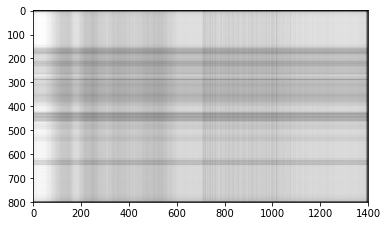

In [32]:
fft_svd_slider = FloatSlider(min=1, max=gray_img.shape[0], step=1, value=1)

### USER DEFINED PARAMETERS ###
fft_thresh = 0.0003

# i is the number of singular values used to make the image
@interact(i=fft_svd_slider)
def plot_image_using_fft_singular_values(i):
    i = int(i)
    img_fft = fft.fft2(gray_img)
    M = np.max(np.abs(img_fft))
    
    truncated_fft_img = (np.abs(img_fft) > M*fft_thresh) * img_fft
    U_fft, Sigma_fft, Vh_fft = sp.linalg.svd(truncated_fft_img)
    
    
    U_fft_1 = np.matrix(U_fft[:,:i])
    Sigma_fft_1 = np.diag(Sigma_fft[:i])
    V_fft_t = np.matrix(Vh_fft[:i, :])
    
    reconstructed_fft_img = U_fft_1* Sigma_fft_1 * V_fft_t
    
    fully_reconstructed_img = np.real(fft.ifft2(reconstructed_fft_img))
    plt.imshow(fully_reconstructed_img, cmap=plt.cm.gray)

# Optimal Compression Subject to Cost Function

Cost function for error and compression ratios of the form $C = a\rho + bR$;
$\rho =$ Error and $R =$ compression ratio

In [109]:
def cost_function(error, compression_ratio):
    return error + compression_ratio

def optimal_compression(img, cost_function, img_type):
    m = img.shape[0]
    num_pixels = np.prod(img.shape)
    
    best_picture = img
    current_min = float('inf')
    
    
    if img_type == 'gray':
        U, Sigma, Vh = sp.linalg.svd(img)

        for i in range(1,m):
            compression_ratio = (np.matrix(U[:,:i]).size + Sigma[:i].size + np.matrix(Vh[:i, :]).size)/num_pixels
            approx_A = np.dot(U[:,:i], np.dot(np.diag(Sigma[:i]), Vh[:i, :]))
            error = ((LA.norm(img - approx_A)**2)/(LA.norm(img)**2))*100

            func_val = cost_function(error, compression_ratio)
            if func_val < current_min:
                best_picture = approx_A

        return best_picture
    
    if img_type == 'rgb':
        red = img[:, :, 0]
        green = img[:, :, 1]
        blue = img[:, :, 2]
        
        red_U, red_S, red_V = sp.linalg.svd(red)
        green_U, green_S, green_V = sp.linalg.svd(green)
        blue_U, blue_S, blue_V = sp.linalg.svd(blue)
        
        for i in range(1,m):
            compression_ratio = ((np.matrix(red_U[:,:i]).size + red_S[:i].size + np.matrix(red_V[:i, :]).size)*3)/num_pixels
            rgbArray = np.zeros(img.shape, 'uint8')
            for ix, color_matrix in enumerate([[red_U, red_S, red_V], [green_U, green_S, green_V], [blue_U, blue_S, blue_V]]):
                rgbArray[:,:, ix] = np.dot(color_matrix[0][:,:i], np.dot(np.diag(color_matrix[1][:i]), color_matrix[2][:i, :]))
            error = ((LA.norm(img - rgbArray)**2)/(LA.norm(img)**2))*100

            func_val = cost_function(error, compression_ratio)
            if func_val < current_min:
                best_picture = rgbArray
        return best_picture        
        

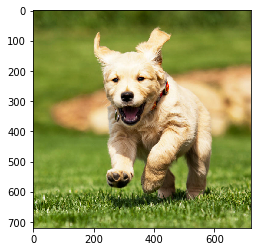

In [110]:
plt.imshow(optimal_compression(rgb_img, cost_function, 'rgb'), cmap=plt.cm.gray)

Bytes Used: 4323
Compression Ratio 0.00277970679012


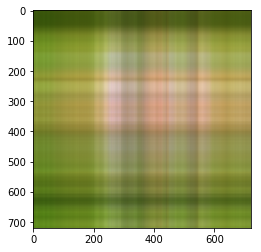

In [93]:
color_svd_slider = FloatSlider(min=1, max=rgb_img.shape[0], step=1, value=1)

# i is the number of singular values used to make the image
@interact(i=color_svd_slider)
def plot_image_using_singular_values(i):
    i = int(i)
    total_bytes = 0
    
    red = rgb_img[:, :, 0]
    green = rgb_img[:, :, 1]
    blue = rgb_img[:, :, 2]
    
    rgbArray = np.zeros(rgb_img.shape, 'uint8')
    for ix, color_matrix in enumerate([red, green, blue]):
        U, S, V = sp.linalg.svd(color_matrix)
        total_bytes += np.matrix(U[:,:i]).size + S[:i].size + np.matrix(V[:i, :]).size
        rgbArray[:,:, ix] = np.dot(U[:,:i], np.dot(np.diag(S[:i]), V[:i, :]))
        
    print("Bytes Used:", total_bytes)
    print("Compression Ratio", total_bytes/np.prod(rgb_img.shape))
    
    plt.imshow(rgbArray, cmap=plt.cm.gray)

In [9]:
obama = ndimage.imread('data/obama.png')

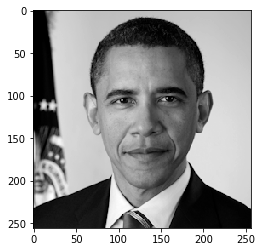

In [225]:
plt.imshow(obama, cmap=plt.cm.gray)

In [4]:
W1 = np.matrix([[0.5, 0,   0,   0,   0.5,  0,    0,    0],
                [0.5, 0,   0,   0,   -0.5, 0,    0,    0],
                [0,   0.5, 0,   0,   0,    0.5,  0,    0],
                [0,   0.5, 0,   0,   0,    -0.5, 0,    0],
                [0,   0,   0.5, 0,   0,    0,    0.5,  0],
                [0,   0,   0.5, 0,   0,    0,    -0.5, 0],
                [0,   0,   0,   0.5, 0,    0,    0,    0.5],
                [0,   0,   0,   0.5, 0,    0,    0,    -0.5]])

W2 = np.matrix([[0.5, 0,   0.5,  0,    0, 0, 0, 0],
                [0.5, 0,   -0.5, 0,    0, 0, 0, 0],
                [0,   0.5, 0,    0.5,  0, 0, 0, 0],
                [0,   0.5, 0,    -0.5, 0, 0, 0, 0],
                [0,   0,   0,    0,    1, 0, 0, 0],
                [0,   0,   0,    0,    0, 1, 0, 0],
                [0,   0,   0,    0,    0, 0, 1, 0],
                [0,   0,   0,    0,    0, 0, 0, 1]])

W3 = np.matrix([[0.5, 0.5,  0, 0, 0, 0, 0, 0],
                [0.5, -0.5, 0, 0, 0, 0, 0, 0],
                [0,   0,    1, 0, 0, 0, 0, 0],
                [0,   0,    0, 1, 0, 0, 0, 0],
                [0,   0,    0, 0, 1, 0, 0, 0],
                [0,   0,    0, 0, 0, 1, 0, 0],
                [0,   0,    0, 0, 0, 0, 1, 0],
                [0,   0,    0, 0, 0, 0, 0, 1]])

W = W1*W2*W3

In [239]:
# Get all of the 8x8 submatrices (windows)
windows = sliding_window(obama, (8,8), flatten=False)
template = np.zeros(windows.shape)

Apply  $$ S = W^{T}AW $$
to all 8x8 submatrices

In [240]:
def haar_transform(sub_matrix,val):
    return np.matmul(np.matmul(W.T,sub_matrix),W)

In [243]:
for i, x in enumerate(windows):
    for j, y in enumerate(x):
        template[i][j] = np.apply_over_axes(dhwt, windows[i][j], [1])

8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8) (8, 8)
8 8 (8, 8)

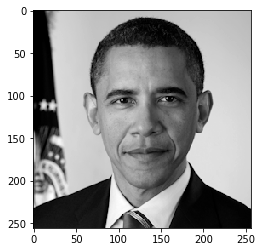

In [245]:
plt.imshow(np.ma.row_stack([np.ma.column_stack(window) for window in windows]),cmap=plt.cm.gray)

In [246]:
stored_image = np.ma.row_stack([np.ma.column_stack(template_window) for template_window in template])

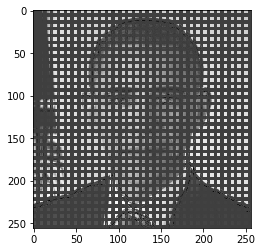

In [247]:
plt.imshow(stored_image, cmap=plt.cm.gray)

In [248]:
compressed_windows = sliding_window(stored_image, (8,8), flatten=False)
reconstructed_template = np.zeros(windows.shape)

Apply $$A = (W^{T})^{-1}SW^{-1}$$
to all "haar transformed" submatrices

In [15]:
def inverse_haar(sub_matrix,val):
    return np.matmul(np.matmul(LA.inv(W.T),sub_matrix),LA.inv(W))

In [249]:
for i, x in enumerate(compressed_windows):
    for j, y in enumerate(x):
        reconstructed_template[i][j] = np.apply_over_axes(idhwt, compressed_windows[i][j], [1])

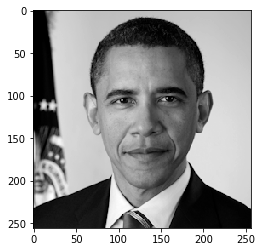

In [250]:
plt.imshow(np.ma.row_stack([np.ma.column_stack(re_temp) for re_temp in reconstructed_template]),cmap=plt.cm.gray)

In [251]:
M = np.max(np.abs(stored_image))
filtered_image = (np.abs(stored_image) > M*0.1) * stored_image

In [252]:
np.max(filtered_image)

964.0

In [253]:
len(filtered_image[np.where(filtered_image>0)])

13620

In [254]:
len(obama[np.where(obama>0)])

63497

In [91]:
filtered_windows = sliding_window(filtered_image, (8,8), flatten=False)
for i, x in enumerate(filtered_windows):
    for j, y in enumerate(x):
        reconstructed_template[i][j] = np.apply_over_axes(inverse_haar, filtered_windows[i][j], [0])

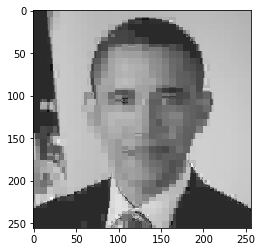

In [92]:
plt.imshow(np.ma.row_stack([np.ma.column_stack(re_temp) for re_temp in reconstructed_template]),cmap=plt.cm.gray)

In [ ]:
# Get all of the 8x8 submatrices (windows)
windows = sliding_window(obama, (8,8), flatten=False)
template = np.zeros(windows.shape)



In [255]:
haar_slider = FloatSlider(min=0, max=0.5, step=0.01, value=0.01)
M = np.max(np.abs(stored_image))

# i is the number of singular values used to make the image
@interact(thresh=haar_slider)
def plot_image_using_haar(thresh):
    filtered_image = (np.abs(stored_image) > M*thresh) * stored_image
    filtered_windows = sliding_window(filtered_image, (8,8), flatten=False)
    filtered_template = np.zeros(filtered_windows.shape)
    
    for i, x in enumerate(filtered_windows):
        for j, y in enumerate(x):
            filtered_template[i][j] = np.apply_over_axes(inverse_haar, filtered_windows[i][j], [0])
    
    print(thresh)
    print((len(filtered_image[np.where(filtered_image>0)])*3)/np.prod(gray_img.shape))
    #print("Number of non-zero entries in filtered image: {0}".format(len(filtered_image[np.where(filtered_image>0)])))
    #print("Number of non-zero entires in original image: {0}".format(len(obama[np.where(obama>0)])))
    plt.imshow(np.ma.row_stack([np.ma.column_stack(re_temp) for re_temp in filtered_template]),cmap=plt.cm.gray)

NameError: name 'inverse_haar' is not defined

In [104]:
# application -- satellites sending back massive images

# Discrete Haar Wavelet Transformation

Try to send vector $\textbf{x} = (x_1, x_2,...,x_n)$

Approximate data with with pair-wise averages.

$$s_k = \frac{x_{2k-1}+x_{2k}}{2}, k=1,2,...,n$$

Send additional data so that original data is recoverable.

$$d_k = \frac{x_{2k}-x_{2k-1}}{2}, k=1,2,...,n$$

So, this means 

$$s_k + d_k = \frac{x_{2k-1}+x_{2k}}{2} + \frac{x_{2k}-x_{2k-1}}{2} = x_{2k}$$

$$s_k - d_k = \frac{x_{2k-1}+x_{2k}}{2} - \frac{x_{2k}-x_{2k-1}}{2} = x_{2k-1}$$


How can we express this as a matrix equation? (n=8 example)

$$
W_{8}\textbf{x} = \frac{1}{2} 
\begin{bmatrix}
        x_1 + x_2 \\
        x_3 + x_4 \\
        x_5 + x_6 \\
        x_7 + x_8 \\
        \hline
        x_1 - x_2 \\
        x_3 - x_4 \\
        x_5 - x_6 \\
        x_7 - x_8 \\
\end{bmatrix} 
$$

So 

$$W_8 = 
\begin{bmatrix}
        1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 \\
        \hline
        -1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & -1 & 1 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & -1 & 1 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & -1 & 1 \\
\end{bmatrix} \
$$

Let's add some more notation and definitions for convenience and clarity later.

$W_{n} = \begin{bmatrix}
        H \\
        \hline
        G
\end{bmatrix}$
so 
$W_{n}\textbf{x} = \begin{bmatrix}
        H\textbf{x} \\
        \hline
        G\textbf{x}
\end{bmatrix}$

Notice we can rearrange the equation:
$$\frac{1}{2}H\textbf{x} = 
\begin{bmatrix}
        \frac{1}{2} & \frac{1}{2} & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & \frac{1}{2} & \frac{1}{2} & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & \frac{1}{2} & \frac{1}{2} & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & \frac{1}{2} & \frac{1}{2} \\
\end{bmatrix} \cdot 
\begin{bmatrix}
        x_1 \\
        x_2 \\
        x_3 \\
        x_4 \\
        x_5 \\
        x_6 \\
        x_7 \\
        x_8 \\
\end{bmatrix} = \frac{1}{2} 
\begin{bmatrix}
        x_1 + x_2 \\
        x_3 + x_4 \\
        x_5 + x_6 \\
        x_7 + x_8 \\
\end{bmatrix} = 
\begin{bmatrix}
        x_1 & x_2 \\
        x_3 & x_4 \\
        x_5 & x_6 \\
        x_7 & x_8 \\
\end{bmatrix} \cdot
\begin{bmatrix}
        \frac{1}{2} \\
        \frac{1}{2} \\
\end{bmatrix} 
$$

Similarly
$$ \frac{1}{2}G\textbf{x} =
\begin{bmatrix}
        x_1 & x_2 \\
        x_3 & x_4 \\
        x_5 & x_6 \\
        x_7 & x_8 \\
\end{bmatrix} \cdot
\begin{bmatrix}
        \frac{1}{2} \\
        -\frac{1}{2} \\
\end{bmatrix} 
$$

Our stored (and theoretically "compressed") matrix is now $
\left[
\begin{array}{c|c}
        \textbf{s} & \textbf{d}
\end{array}
\right]$

We can also reverse this process. (2 comes from the inverse of $\frac{1}{2}$)

$$2W^{-1}
\left[
\begin{array}{c|c}
        \textbf{s} & \textbf{d}
\end{array}
\right] = 2W^{-1}y = 2W^{-1}
\begin{bmatrix}
        y_1 \\
        y_2 \\
        y_3 \\
        y_4 \\
        y_5 \\
        y_6 \\
        y_7 \\
        y_8 \\
\end{bmatrix} =
\begin{bmatrix}
        y_1 - y_5 \\
        y_1 + y_5 \\
        y_2 - y_6 \\
        y_2 + y_6 \\
        \hline
        y_3 - y_7 \\
        y_3 + y_7 \\
        y_4 - y_8 \\
        y_4 + y_8 \\
\end{bmatrix} 
$$

Again we rearrange the equation so $Y = 
\begin{bmatrix}
        y_1 & y_5 \\
        y_2 & y_6 \\
        y_3 & y_7 \\
        y_4 & y_8 \\
\end{bmatrix}$, $\textbf{a} = Y\cdot
\begin{bmatrix}
        1 \\
        -1
\end{bmatrix}$, and $\textbf{b} = Y\cdot
\begin{bmatrix}
        1 \\
        1
\end{bmatrix}$

So after we compute $\textbf{a}$ and $\textbf{b}$ we can return the result in the form $(a_1,b_1,a_2,b_2,...,a_{n/2},b_{n/2})$

Here is a coding example where $\textbf{x} = (1,2,3,4,5,6,7,8)$

In [173]:
x = np.array([1,2,3,4,5,6,7,8])
print(x)

[1 2 3 4 5 6 7 8]


In [163]:
X = np.reshape(x,(4,2))
print(X)

[[1 2]
 [3 4]
 [5 6]
 [7 8]]


In [166]:
hx = np.dot(X,[0.5,0.5])
gx = np.dot(X,[-0.5,0.5])
print("Hx = ",hx,"Gx = ",gx)

Hx =  [ 1.5  3.5  5.5  7.5] Gx =  [ 0.5  0.5  0.5  0.5]


In [167]:
y = np.concatenate([hx,gx])
Y = np.reshape(y,(2,4)).T
print(Y)

[[ 1.5  0.5]
 [ 3.5  0.5]
 [ 5.5  0.5]
 [ 7.5  0.5]]


In [176]:
a = np.dot(Y,[1,-1])
b = np.dot(Y,[1,1])
print("a = ",a,"b = ",b)

a =  [ 1.  3.  5.  7.] b =  [ 2.  4.  6.  8.]


In [177]:
reconstructed_x = np.zeros(len(x))
reconstructed_x[::2] = a
reconstructed_x[1::2] = b
print(reconstructed_x.astype(int))
print("x = reconstructed x?: ",sum(x==reconstructed_x)==len(x))

[1 2 3 4 5 6 7 8]
x = reconstructed x?:  True


## 2D Transformation

We can think of the 2D transformation as a many 1D transformations.

If you have an mxn matrix A you can apply the transformation to the columns with: 

$$W_{m}A$$

You can then apply the transformation to the rows with:

$$AW_{n}^{T}$$

So we can save the transformed matrix as S where:

$$S = W_{m}AW_{n}^{T}$$

In block form the transformation is shown as:

$$ W_{m}AW_{n}^{T} = 
\begin{bmatrix}
        H \\
        \hline
        G
\end{bmatrix}A 
\left[
\begin{array}{c|c}
        H^T & G^T
\end{array}
\right] = 
\begin{bmatrix}
        HA \\
        \hline
        GA
\end{bmatrix} 
\left[
\begin{array}{c|c}
        H^T & G^T
\end{array}
\right] =
\left[
\begin{array}{c|c}
        HAH^T & HAG^T \\
        \hline
        GAH^T & GAG^T
\end{array}
\right] = 
\left[
\begin{array}{c|c}
        \mathcal{B} & \mathcal{V} \\
        \hline
        \mathcal{H} & \mathcal{D}
\end{array}
\right]$$

$\mathcal{B}$ = blur because it is the column and row averages of the original image.


$\mathcal{V}$ = vertical differences between (horizontal) pairs of pixels


$\mathcal{H}$ = horizontal differences between (vertical) pairs of pixels


$\mathcal{D}$ = diagonal differences between (diagonal) pairs of pixels

In [38]:
def isEven(x):
    return x%2==0

def num_even_divisions(x):
    s = str(bin(x))
    return len(s) - len(s.rstrip('0'))
    
def generateW(n):
    H = np.zeros((int(n/2),n))
    G = np.zeros((int(n/2),n))
    count = 0
    for x in range(0,int(n/2)):
        H[x][count] = 1
        G[x][count] = -1
        H[x][count+1] = 1
        G[x][count+1] = 1
        count+=2
    return np.row_stack([H,G])

# This is really dhwt2d but whatever.
def dhwt(img,layers=1):
    if layers == 0:
        return img
    m, n = img.shape
    template = np.zeros((m,n))
    iterations = min(num_even_divisions(m),num_even_divisions(n))
    S = np.copy(img)
    for i in reversed(range((iterations+1)-layers ,iterations+1)):
        if isEven(m) and isEven(n):
            W = generateW(min(m,n))
            template[:m][:, 0:n] = np.matmul(np.matmul(generateW(m),S[:m][:, 0:n]),generateW(n).T)
            m, n = int(m/2), int(n/2)
            S = template[:m][:, 0:n]
        
    return template

def idhwt(img,layers=1):
    if layers == 0:
        return img
    m, n = img.shape
    template = np.zeros((m,n))
    iterations = min(num_even_divisions(m),num_even_divisions(n))
    S = np.copy(img)
    m, n = int(m/(2**(layers-1))), int(n/(2**(layers-1)))
    for i in range((iterations+1)-layers,iterations+1):
        template[:m][:, 0:n] = np.matmul(np.matmul(generateW(m).T,S[:m][:, 0:n]),generateW(n))
        m, n = int(m*2), int(n*2)
        S = template[:m][:, 0:n]

    return template

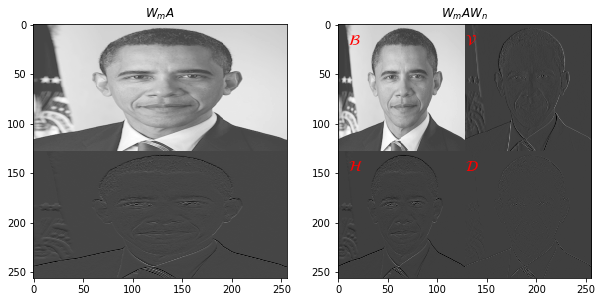

In [193]:
f = plt.figure(figsize=(10,10))
f.add_subplot(1,2,1)
plt.title(r'$W_m A$')
show(np.matmul(generateW(gray_img.shape[0]),gray_img))

S = dhwt(gray_img,layers=1)
#f.add_subplot(1,2,2)
ax = f.add_subplot(1,2,2)
plt.title(r'$W_m A W_n$')
ax.annotate(r'$\mathcal{B}$', xy=(100, 100), xytext=(10, 20), color='red', fontsize=15)
ax.annotate(r'$\mathcal{V}$', xy=(100, 100), xytext=(gray_img.shape[0]/2, 20), color='red', fontsize=15)
ax.annotate(r'$\mathcal{H}$', xy=(100, 100), xytext=(10, gray_img.shape[1]/2+20), color='red', fontsize=15)
ax.annotate(r'$\mathcal{D}$', xy=(100, 100), xytext=(gray_img.shape[0]/2, gray_img.shape[1]/2+20), color='red', fontsize=15)
show(S)

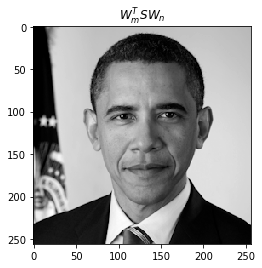

In [183]:
reconstructed_image = idhwt(S)
plt.title(r'$W_m^T S W_n$')
show(reconstructed_image)

It is also possible to threshold values like we did with the FFT compression above. Also, we can choose to compress the image further by doing the HWT on $\mathcal{B}$ once or several times. 

Here is an interactive tool that allows you to adjust the threshold value and number of times you want to recursively transform the blur matrix.

60444.5
1.0
Ratio of number of zero entries in stored (unfiltered) image: number of zero entries in original image
1.0
Ratio of number of zero entries in stored filtered image: number of zero entries in original image
1.0


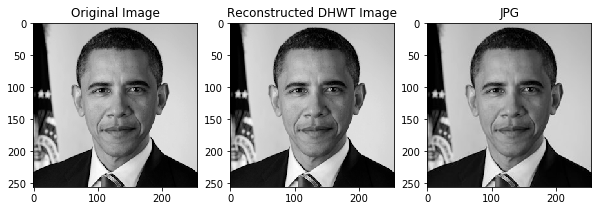

In [44]:
# intial implementation

layers_slider = FloatSlider(min=0, max=min(num_even_divisions(gray_img.shape[0]),num_even_divisions(gray_img.shape[1])), step=1, value=0)
thresh_slider = FloatSlider(min=0.00, max=0.5, step=0.01, value=0.00)

@interact(num_iter=layers_slider,thresh=thresh_slider)
def plot_image_using_singular_values(num_iter,thresh):
    i=int(num_iter)
    stored = dhwt(gray_img, layers=i)
    filtered_image = (np.abs(stored) > np.max(stored)*thresh) * stored
    reconstructed = idhwt(filtered_image,layers=i)
    print(huff_encode_image(filtered_image))
    print(huff_encode_image(filtered_image)/huff_encode_image(gray_img))
    print("Ratio of number of zero entries in stored (unfiltered) image: number of zero entries in original image")
    print(len(stored[np.where(stored>0)])/len(gray_img[np.where(gray_img>0)]))
    
    print("Ratio of number of zero entries in stored filtered image: number of zero entries in original image")
    print(len(filtered_image[np.where(filtered_image>0)])/len(gray_img[np.where(gray_img>0)]))
    
    f = plt.figure(figsize=(10,10))
    f.add_subplot(1, 3, 1)  # this line outputs images side-by-side
    plt.title("Original Image")
    show(gray_img)
    
    f.add_subplot(1,3,2)
    plt.title("Reconstructed DHWT Image")
    show(reconstructed)
    
    f.add_subplot(1,3,3)
    plt.title("JPG")
    show(jpg)

In [204]:
error

'0b10101111000'

In [43]:
jpg = ndimage.imread("/Users/benkaufman/Downloads/obama.jpg")

In [47]:
error(gray_img,jpg)

ValueError: operands could not be broadcast together with shapes (256,256) (256,256,3) 

In [46]:
def error(A,B):
    return ((LA.norm(A - B)**2)/(LA.norm(A)**2))*100

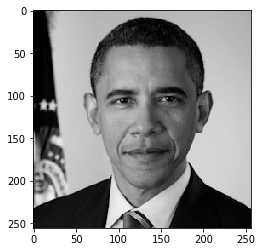

In [67]:
plt.imshow(jpg)

# Huffman Encoding

In [105]:
value, counts = np.unique(gray_img.flatten(),return_counts=True)
#counts = counts/num_pixels
freq = dict(zip(value,counts))

In [92]:
freq = defaultdict(int)
for v, f in zip(value,counts):
    freq[v] = f

In [109]:
huff = encode(freq)
lookup_dict = dict(huff)

In [113]:
total_bits = 0 
for val in gray_img.flatten():
    total_bits += len(lookup_dict[val])

In [114]:
total_bits/8

60444.5

In [116]:
test_img = dhwt(gray_img, layers=1)

In [22]:
def huff_encode_image(img):
    value, counts = np.unique(img.flatten(),return_counts=True)
    frequencies = dict(zip(value,counts))
    
    huff = encode(frequencies)
    lookup_dict = dict(huff)
    
    total_bits = 0 
    for val in img.flatten():
        total_bits += len(lookup_dict[val])
    return (total_bits/8)

In [123]:
huff_encode_image(gray_img)

60444.5


In [124]:
huff_encode_imageencode_image(test_img)

52950.125


In [210]:
def num_even_divisions(x):
    s = str(bin(x))
    return len(s) - len(s.rstrip('0'))

In [211]:
num_even_divisions(1400)

3

In [213]:
H2 = [[1,1],[1,-1]]

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  1., -1., -1.],
       [ 1., -1.,  0., -0.],
       [ 0., -0.,  1., -1.]])

# File Sizes

In [1]:
import os

In [4]:
f = os.stat("data/obama.png")

In [5]:
f.st_size

32650

In [13]:
plt.imsave("data/obama.jpg",obama)

In [14]:
f2 = os.stat("data/obama.png")

In [15]:
f2.st_size

32650

In [16]:
os.stat("/Users/benkaufman/Downloads/obama.jpg").st_size

12904

In [ ]:
#Guetzli